Let's use the same set of 5000 tweets we collected for last week's lecture on sentiment. There are 2500 tweets from the Clinton twitter account, and 2500 tweets from the Trump account.

In [1]:
import pandas as pd
df = pd.read_csv("sentimentanalysis.csv", index_col=0, encoding="latin1")

In [2]:
df.head()

,user,text,source,fav,rt
0,realDonaldTrump,"Remember, don't believe ""sources said"" by the ...",Twitter for Android,8572,3616
1,realDonaldTrump,Did Crooked Hillary help disgusting (check out...,Twitter for Android,12930,5628
2,realDonaldTrump,Using Alicia M in the debate as a paragon of v...,Twitter for Android,12738,5209
3,realDonaldTrump,"Wow, Crooked Hillary was duped and used by my ...",Twitter for Android,13210,5205
4,realDonaldTrump,Anytime you see a story about me or my campaig...,Twitter for Android,21316,9147


We will use the NRC emotion lexicon as a pre-existing knowledge base to assist us in identifying words in tweets that have an association with one of the 8 Ekman emotions. I've downloaded the text file and have included it on Canvas.

We'll use ``read_csv`` to read the lexicon into our environment as a data frame. There are some things of note here, though: first, column values in this ``.txt`` file are separated by tabs. We have to pass a named argument called ``sep`` to indicate to Pandas that the conventional comma is **not** the separater. In Python, a tab is represented as ``\t``, so the argument looks like ``sep="\t"``. Secondly, there is a lot of information about the dataset that is embedded *in* the text file. I opened the text file in an editor and noted that the first 46 rows are metadata about the set. We don't want to read this into our dataframe, of course. Therefore, I pass another named argument, ``skiprows=45``, which tells Pandas to skip the first 46 rows: the value is 45 because, as always, Python starts counting from 0.

In [3]:
nrc = pd.read_csv("NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt", sep="\t", names=["word", "emotion", "association"], skiprows=45)

Let's take a look at how the NRC is formatted. 

In [4]:
nrc.head(25)

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
5,aback,negative,0
6,aback,positive,0
7,aback,sadness,0
8,aback,surprise,0
9,aback,trust,0


The NRC data is formatted a bit strangely. Each word in the NRC, like "aback" and "abacus" has a row with *all 8* Ekman emotions *and* the values "positive" and "negative", which correspond to the sentiment polarity of the word. Then, in the thrid column, a value of ``1`` indicates there *is* a relationship between that word and that emotion/sentiment, and a value of 0 means there is *not* a relationship. 

The researchers may have had a reason for formatting the data this way, but for our purposes we only need to know when there *is* a word-emotion relationship. So I'll filter the data, so we only have rows where the value in the 3rd column is 1. 

In [5]:
nrc = nrc[nrc["association"] == 1]

Furthermore, the sentiment markers of positive and negative may be of interest to you, but since we covered sentiment polarity last week, I'm going to remove all the rows where the value of the second column is ``positive`` and ``negative``, leaving only the emotions.

In [6]:
nrc = nrc[nrc['emotion'].isin(['positive', 'negative']) == False]
nrc.head(25)

,word,emotion,association
19,abacus,trust,1
23,abandon,fear,1
27,abandon,sadness,1
30,abandoned,anger,1
33,abandoned,fear,1
37,abandoned,sadness,1
40,abandonment,anger,1
43,abandonment,fear,1
47,abandonment,sadness,1
48,abandonment,surprise,1


We will now go through the tweets and count how many words representing each emotion is in the tweet. 

To demonstrate, let's first do this with a single tweet.

In [7]:
tweet = df.iloc[3442, :]
print(tweet.text)

RT @AndraDayMusic: I was honored to be a part of history at the DNC. Hillary Clinton is an inspiration for women everywhere.
https://t.co/E


Unfortunately for the us, we don't have a Python equivalent of the AFINN module to do the heavy lifting for us, so we'll have to perform the counting ourselves, using Python. This will be a good exercise, though. 

Note, first of all, that our tweet is a string. We need to split this long string into separate words, since we're interested in obtaining counts of words. To do this, we'll use NLTK. Specifically, NLTK has a special tokenier called ``TweetTokenizer`` that does the usual task of splitting strings into words, but is specially trained to handle Twitter-specific words, like mentions and hashtags. Normally, tokenizers are trained to split symbols from words, so that "#election" because "#" and "election", but ``TweetTokenizer`` knows not to do this. 

In [8]:
from nltk.tokenize import TweetTokenizer

Use the factory method ``TweetTokenizer`` to make an instance of the tokenizer. We'll call it ``tt``.

In [9]:
tt = TweetTokenizer()

In [10]:
tokenized = tt.tokenize(tweet.text)
print(tokenized)

['RT', '@AndraDayMusic', ':', 'I', 'was', 'honored', 'to', 'be', 'a', 'part', 'of', 'history', 'at', 'the', 'DNC', '.', 'Hillary', 'Clinton', 'is', 'an', 'inspiration', 'for', 'women', 'everywhere', '.', 'https://t.co/E']


The words in the NRC are lower-case. If the word ``Abhor``, with a capital ``A``, is in the text, it won't be found in the NRC: Python thinks ``Abhor`` and ``abhor`` are different words.

In anticipation of this, let's lowercase every word in the tokenized tweet.

In [11]:
tokenized = [x.lower() for x in tokenized]
print(tokenized)

['rt', '@andradaymusic', ':', 'i', 'was', 'honored', 'to', 'be', 'a', 'part', 'of', 'history', 'at', 'the', 'dnc', '.', 'hillary', 'clinton', 'is', 'an', 'inspiration', 'for', 'women', 'everywhere', '.', 'https://t.co/e']


Now we're ready to go through all the tokens and count how many times emotion words appear. 

First, I need to make an inventory of the emotions available to us. 

In [12]:
emotions = list(set(nrc['emotion']))
print(emotions)

['joy', 'disgust', 'anger', 'anticipation', 'fear', 'surprise', 'sadness', 'trust']


The list ``emotions`` is in an arbitrary order, but we'll use this ordering to create a **count vector** for each tweet. That is, we'll represent each tweet as a vector of length 9, where the first element is the count of how many trust words occurred in it, and the second element is a count of how many anticipation words occurred in it, and so on. 

To help us do this as we iterate through the tweets, I'm going to make a dictionary. The first will tell me **given an index number, what is its corresponding emotion** and the second will tell me **given an emotion, what is its corresponding index number**. 

In [13]:
index2emotion = {}
emotion2index = {}

for i in range(len(emotions)):
    index2emotion[i] = emotions[i]
    emotion2index[emotions[i]] = i

With these two dictionaries, if I have an index, I can get an emotion, and if I have an emotion, I can get its index.

In [14]:
print(emotions)

['joy', 'disgust', 'anger', 'anticipation', 'fear', 'surprise', 'sadness', 'trust']


In [15]:
# What is the position index of the emotion "fear"?
emotion2index['fear']

4

In [16]:
# What emotion is associated with position index 6?
index2emotion[6]

'sadness'

Now, let's initialize a count vector for the single tweet we're working with. We're going to initialize all values to 0.

In [17]:
cv = [0] * len(emotions)
print(cv)

[0, 0, 0, 0, 0, 0, 0, 0]



ow, we will iterate through each word in the tweet, and find what emotions are associated with it in the ``nrc`` data frame. 

In [18]:
for token in tokenized:
    # Subset NRC to contain ONLY the rows associated with *this* word
    sub = nrc[nrc['word'] == token]
    # Isolate the column emotion from sub; these are the emotions associated with this word
    token_emotions = sub['emotion']
    for e in token_emotions:
        # e represents one of the emotions associated with this token
        # What is the position index associated with this emotion?
        position_index = emotion2index[e]
        # Increment the variable cv at *this* position index by 1
        cv[position_index] += 1

Now that we've run this code, let's take a look at ``cv``. 

In [19]:
cv

[1, 0, 0, 1, 0, 0, 0, 0]

Notice that all the values are 0 except for index 1 element and the index 5. This means that this tweet contained 1 instance of a word associated with:

In [20]:
index2emotion[1]

'disgust'

and 1 instance of a word associated with:

In [21]:
index2emotion[5]

'surprise'

Let's take everything we've done above and package it into a function, since we'll be performing these steps for every tweet.

In [22]:
# Repeating this code, this has to be run for the function to work
emotions = list(set(nrc['emotion']))
index2emotion = {}
emotion2index = {}
for i in range(len(emotions)):
    index2emotion[i] = emotions[i]
    emotion2index[emotions[i]] = i
    
# Here is the function
# Assumes that a TweetTokenizer called tt has been made
# and that the NRC lexicon has been imported as nrc
def makeEmoVector(tweettext):
    cv = [0] * len(emotions)
    tokenized = tt.tokenize(tweettext)
    tokenized = [x.lower() for x in tokenized]
    for token in tokenized:
        sub = nrc[nrc['word'] == token]
        token_emotions = sub['emotion']
        for e in token_emotions:
            position_index = emotion2index[e]
            cv[position_index] += 1
    return cv

Now we can take an arbitrary tweet and represent it as an emotion vector. Using this function, let's go ahead and create an emotion vector for every tweet. 

In [23]:
emotion_vectors = []
for text in df['text']:
    emotion_vector = makeEmoVector(text)
    emotion_vectors.append(emotion_vector)

And now, let's make the emotion vectors in to a data fram.e

In [24]:
ev = pd.DataFrame(emotion_vectors, index=df.index, columns=emotions)
ev.head()

,joy,disgust,anger,anticipation,fear,surprise,sadness,trust
0,0,1,1,0,0,0,1,0
1,1,1,1,1,1,0,0,1
2,1,1,1,1,1,0,1,2
3,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0


Finally, let's merge this data frame with the data frame of original tweets. 

In [25]:
df = df.join(ev)
df.head()

,user,text,source,fav,rt,joy,disgust,anger,anticipation,fear,surprise,sadness,trust
0,realDonaldTrump,"Remember, don't believe ""sources said"" by the ...",Twitter for Android,8572,3616,0,1,1,0,0,0,1,0
1,realDonaldTrump,Did Crooked Hillary help disgusting (check out...,Twitter for Android,12930,5628,1,1,1,1,1,0,0,1
2,realDonaldTrump,Using Alicia M in the debate as a paragon of v...,Twitter for Android,12738,5209,1,1,1,1,1,0,1,2
3,realDonaldTrump,"Wow, Crooked Hillary was duped and used by my ...",Twitter for Android,13210,5205,1,1,1,1,1,1,1,1
4,realDonaldTrump,Anytime you see a story about me or my campaig...,Twitter for Android,21316,9147,0,0,0,0,0,0,0,0


Note that *at the level of a tweet*, this method will probably produce some visible inaccurate judgements. We're assigning emotions to tweets based solely on the presence of absence of words, and there are bound to be some errors. Nevertheless, such "noise", ideally, can be washed out by viewing things in aggregate. Let's use Pandas, for example, to see how the emotions show up across *all* of the tweets by each of the candidates.

In [26]:
cand_group = df.groupby("user")

In [27]:
emo_counts = cand_group[emotions].agg("sum")
emo_counts

,joy,disgust,anger,anticipation,fear,surprise,sadness,trust
user,,,,,,,,
HillaryClinton,966,352,852,1236,939,1077,810,1865
realDonaldTrump,818,545,897,970,810,727,862,1467


We can perform an initialize comparison of the emotions here, but it would be better if we normalized these counts. It's true that Tweets have built-in word limitations, but it's still entirely possible that across these 5000 tweets, the two candidates used different amounts of words. Let's get the total number of words tweeted by each candidate.

In [28]:
clintoncount = 0
clintonsub = df[df['user'] == "HillaryClinton"]
for text in clintonsub['text']:
    clintoncount += len(tt.tokenize(text))
print(clintoncount)

55583


In [29]:
trumpcount = 0
trumpsub = df[df['user'] == "realDonaldTrump"]
for text in trumpsub['text']:
    trumpcount += len(tt.tokenize(text))
print(trumpcount)

51413


Using a Pandas function called ``divide``, I'll divide each row in the emotion sums table by the total number of words.

In [30]:
emo_counts_normalized = emo_counts.divide([clintoncount, trumpcount], axis="rows")
emo_counts_normalized

,joy,disgust,anger,anticipation,fear,surprise,sadness,trust
user,,,,,,,,
HillaryClinton,0.017379,0.006333,0.015328,0.022237,0.016894,0.019376,0.014573,0.033553
realDonaldTrump,0.015910,0.010600,0.017447,0.018867,0.015755,0.014140,0.016766,0.028534


This table will be a little easier to understnad if we visualize it. 

In passing: we learned how to use ``matplotlib`` to create visualizations, and this is a useful skill, but one of the neat things about Pandas is that as long as you import matplotlib [you can use functions written into Pandas for the visualization of data frames](http://pandas.pydata.org/pandas-docs/stable/visualization.html). I'm going to do that here to speed things up.  In order to display the bar chart I want, I need to flip the data frame so that the emotions are the rows and the candidates are the columns, so I accomplish this by calling the Pandas function ``transpose()``. 

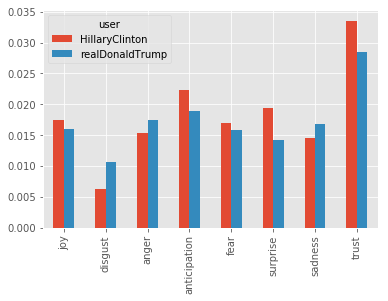

In [31]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
emo_counts_normalized.transpose().plot.bar()

Clinton seems to use words associated with trust, anticipation, and surprise more, while Trump has a lead in words expressing disgust. For the others the values are a bit more even. 

We can also explore differences in tweet source in Trump's tweets, doing something similar to the study we explored in the first lecture.

In [32]:
trump = df[df['user'] == "realDonaldTrump"]
trump = trump[trump['source'].isin(["Twitter for Android", "Twitter for iPhone"])]
source_group = trump.groupby("source")
emo_aggs = source_group[emotions].agg("sum")
emo_aggs

,joy,disgust,anger,anticipation,fear,surprise,sadness,trust
source,,,,,,,,
Twitter for Android,479,366,570,562,504,453,539,828
Twitter for iPhone,292,139,251,346,231,222,247,530


In [33]:
android_count = 0

for text in trump[trump['source'] == "Twitter for Android"]['text']:
    android_count += len(tt.tokenize(text))
    
iphone_count = 0

for text in trump[trump['source'] == "Twitter for iPhone"]['text']:
    iphone_count += len(tt.tokenize(text))
    
print("Android word_count: " + str(android_count))
print("iPhone word count: " + str(iphone_count))

Android word_count: 28878
iPhone word count: 18601


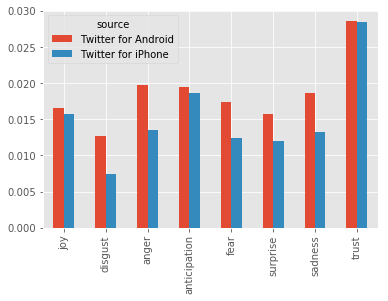

In [34]:
emo_aggs_normalized = emo_aggs.divide([android_count, iphone_count], axis="rows")
emo_aggs_normalized.transpose().plot.bar()

Just like in David Robinson's analysis, we can also come to the conlusion that the Android user writes significantly more angry tweets than the iPhone user. This also seems to be the case for anger, disgust, sadness, and fear, as well. 